In [122]:
import gzip
import csv
import json
import pandas as pd
import numpy as np
import datetime
import time
import collections
from collections import Counter
import matplotlib.pyplot as plt
import math
from math import log, exp
from datetime import datetime, timedelta
from pytz import timezone
import datetime
from matplotlib.pyplot import figure
from scipy.stats import pearsonr


### 1. Data downloading

In [169]:
# download a file of trades for the S&P 500 E‐mini futures contract

minitr = pd.read_csv('ESM10-trades-2010-05-06.csv', sep=',' )
minitr['Date-Time'] =  pd.to_datetime(minitr['Date-Time'], format='%Y-%m-%dT%H:%M:%S.%f')

#download a file of quotes for the S&P 500 E‐mini futures contract

miniqu = pd.read_csv('ESM10-quotes-2010-05-06.csv', sep=',' )
miniqu['Date-Time'] =  pd.to_datetime(miniqu['Date-Time'], format='%Y-%m-%dT%H:%M:%S.%f')

#download a file of trades for the SPDR ETF

etftr = pd.read_csv('SPY-trades-2010-05-06.csv', sep=',' )
etftr['time_m'] = pd.to_datetime(etftr['time_m'], format='%H:%M:%S.%f')

#download a file of quotes for the SPDR ETF

etfqu = pd.read_csv('SPY-raw-quotes-2010-05-06.csv', sep=',' )
etfqu['time_m'] = pd.to_datetime(etfqu['time_m'], format='%H:%M:%S.%f')


Взглянем на то, как выглядят данные:

In [170]:
print(minitr.head(3))
print(miniqu.head(3))

                         Date-Time   Price  Volume
0 2010-05-06 12:00:00.147029+00:00  1163.0     4.0
1 2010-05-06 12:00:00.147029+00:00  1163.0    10.0
2 2010-05-06 12:00:00.147029+00:00  1163.0     1.0
                         Date-Time  Bid Price  Bid Size  Ask Price  Ask Size
0 2010-05-06 12:00:00.177280+00:00    1162.75     281.0        NaN       NaN
1 2010-05-06 12:00:00.177280+00:00        NaN       NaN     1163.0       4.0
2 2010-05-06 12:00:00.177280+00:00        NaN       NaN     1163.0      44.0


In [171]:
etftr.head(3)

,sym_root,sym_suffix,date,time_m,price,size,exchange
0,SPY,,20100506,1900-01-01 09:30:00.044,116.26,200,B
1,SPY,,20100506,1900-01-01 09:30:00.046,116.26,200,B
2,SPY,,20100506,1900-01-01 09:30:00.046,116.26,100,B


In [172]:
etfqu.head(3)

,sym_root,sym_suffix,date,time_m,exchange,bid,ask,bidsize,asksize
0,SPY,,20100506,1900-01-01 09:30:00.011,Z,116.24,116.26,38,42
1,SPY,,20100506,1900-01-01 09:30:00.013,Z,116.24,116.26,38,41
2,SPY,,20100506,1900-01-01 09:30:00.017,Z,116.24,116.26,38,43


In [173]:
set(etfqu['exchange'])

{'B', 'C', 'I', 'M', 'P', 'T', 'W', 'Z'}

In [174]:
set(etftr['exchange'])

{'B', 'C', 'D', 'I', 'M', 'P', 'T', 'W', 'Z'}

Посмотрим на примерное распределение записей по биржам:

In [175]:
etfqu.groupby(['exchange'])["sym_root"].count()

exchange
B     716155
C     260699
I     853474
M     208183
P    1989452
T    1484302
W      64700
Z    2185892
Name: sym_root, dtype: int64

In [176]:
etftr.groupby(['exchange'])['sym_root'].count()

exchange
B     97060
C      5452
D    216585
I     17386
M      3345
P    323735
T    493514
W      1053
Z    326849
Name: sym_root, dtype: int64

We can observe that there is no information of quotes for FINRA ADF

### 2. Data cleaning

In [177]:
# excluding all bad observations with price or size of 0

index1 = len(list(np.where (minitr['Price'] == 0)))-1
minitr = minitr.drop(minitr[minitr['Price'] == 0].index) 
index2 = len(list(np.where (minitr['Volume'] == 0)))-1
minitr = minitr.drop(minitr[minitr['Volume'] == 0].index)

index3 = len(list(np.where (miniqu['Bid Price'] == 0)))-1
miniqu = miniqu.drop(miniqu[miniqu['Bid Price'] == 0].index)
index4 = len(list(np.where (miniqu['Ask Price'] == 0)))-1
miniqu = miniqu.drop(miniqu[miniqu['Ask Price'] == 0].index)
index5 = len(list(np.where (miniqu['Bid Size'] == 0)))-1
miniqu = miniqu.drop(miniqu[miniqu['Bid Size'] == 0].index)
index6 = len(list(np.where (miniqu['Ask Size'] == 0)))-1
miniqu = miniqu.drop(miniqu[miniqu['Ask Size'] == 0].index)

index7 = len(list(np.where (etftr['price'] == 0)))-1
etftr = etftr.drop(etftr[etftr['price'] == 0].index)
index8 = len(list(np.where (etftr['size'] == 0)))-1
etftr = etftr.drop(etftr[etftr['size'] == 0].index)

index9 = len(list(np.where (etfqu['bid'] == 0)))-1
etfqu = etfqu.drop(etfqu[etfqu['bid'] == 0].index)
index10 = len(list(np.where (etfqu['ask'] == 0)))-1
etfqu = etfqu.drop(etfqu[etfqu['ask'] == 0].index)
index11 = len(list(np.where (etfqu['bidsize'] == 0)))-1
etfqu = etfqu.drop(etfqu[etfqu['bidsize'] == 0].index)
index12 = len(list(np.where (etfqu['asksize'] == 0)))-1
etfqu = etfqu.drop(etfqu[etfqu['asksize'] == 0].index)

In [178]:
#make sure we have not bad observations with price or size of 0
print(index1, index2, index3, index4, index5, index6, index7, index8, index9, index10, index11, index12)

0 0 0 0 0 0 0 0 0 0 0 0


Мы убедились, что по этому критерию (наличие нулевой цены или нулевого объёма) нам были предоставлены чистые данные. (Также привели код на случай, если бы данные не были такими чистыми)

In [179]:
#separation of exchanges [for quotes]
BB = etfqu[etfqu['exchange'] == 'B']
CC = etfqu[etfqu['exchange'] == 'C']
II = etfqu[etfqu['exchange'] == 'I']
MM = etfqu[etfqu['exchange'] == 'M']
PP = etfqu[etfqu['exchange'] == 'P']
TT = etfqu[etfqu['exchange'] == 'T']
WW = etfqu[etfqu['exchange'] == 'W']
ZZ = etfqu[etfqu['exchange'] == 'Z']

In [180]:
# excluding "crossed market": when bid price exceeds ask price 
index13 = len(list(np.where (miniqu['Bid Price'] > miniqu['Ask Price'])))-1
miniqu = miniqu.drop(miniqu[miniqu['Bid Price'] > miniqu['Ask Price']].index)

index14 = len(list(np.where (BB['bid'] > BB['ask'])))-1
BB = BB.drop(BB[BB['bid'] > BB['ask']].index)

index15 = len(list(np.where (CC['bid'] > CC['ask'])))-1
CC = CC.drop(CC[ CC['bid'] > CC['ask'] ].index)

index16 = len(list(np.where (II['bid'] > II['ask'])))-1
II = II.drop(II[II['bid'] > II['ask']].index)

index17 = len(list(np.where (MM['bid'] > MM['ask'])))-1
MM = MM.drop(MM[MM['bid'] > MM['ask']].index)

index18 = len(list(np.where (PP['bid'] > PP['ask'])))-1
PP = PP.drop(PP[PP['bid'] > PP['ask']].index)

index19 = len(list(np.where (TT['bid'] > TT['ask'])))-1
TT = TT.drop(TT[TT['bid'] > TT['ask']].index)

index20 = len(list(np.where (WW['bid'] > WW['ask'])))-1
WW = WW.drop(BB[BB['bid'] > BB['ask']].index)

index21 = len(list(np.where (ZZ['bid'] > ZZ['ask'])))-1
ZZ = ZZ.drop(ZZ[ZZ['bid'] > ZZ['ask']].index)



In [181]:
#make sure we have not  "crossed market"
print(index13, index14, index15, index16, index17, index18, index19, index20, index21)

0 0 0 0 0 0 0 0 0


In [182]:
# excluding "locked market": when bid price equals ask price

index13 = len(list(np.where (miniqu['Bid Price'] == miniqu['Ask Price'])))-1
miniqu = miniqu.drop(miniqu[miniqu['Bid Price'] == miniqu['Ask Price']].index)

index14 = len(list(np.where (BB['bid'] == BB['ask'])))-1
BB = BB.drop(BB[BB['bid'] == BB['ask']].index)

index15 = len(list(np.where (CC['bid'] == CC['ask'])))-1
CC = CC.drop(CC[CC['bid'] == CC['ask']].index)

index16 = len(list(np.where (II['bid'] == II['ask'])))-1
II = II.drop(II[II['bid'] == II['ask']].index)

index17 = len(list(np.where (MM['bid'] == MM['ask'])))-1
MM = MM.drop(MM[MM['bid'] == MM['ask']].index)

index18 = len(list(np.where (PP['bid'] == PP['ask'])))-1
PP = PP.drop(PP[PP['bid'] == PP['ask']].index)

index19 = len(list(np.where (TT['bid'] == TT['ask'])))-1
TT = TT.drop(TT[TT['bid'] == TT['ask']].index)

index20 = len(list(np.where (WW['bid'] == WW['ask'])))-1
WW = WW.drop(WW[WW['bid'] == WW['ask']].index)

index21 = len(list(np.where (ZZ['bid'] == ZZ['ask'])))-1
ZZ = ZZ.drop(ZZ[ZZ['bid'] == ZZ['ask']].index)



In [183]:
#make sure we have not  "locked market"
print(index13, index14, index15, index16, index17, index18, index19, index20, index21)

0 0 0 0 0 0 0 0 0


Аналогично мы понимаем, что изначально в данных нет "locked market" и "crossed market"

In [184]:
# Addressing the time zone issues: adjusting to New York time 

miniqu['Date-Time'] = miniqu['Date-Time']- timedelta(hours=4)
minitr['Date-Time'] = minitr['Date-Time']- timedelta(hours=4)


In [188]:
time_str = '09:30:00'
time_object = datetime.datetime.strptime(time_str, '%H:%M:%S').time()
minitr['not in time'] = minitr['Date-Time'].dt.time < time_object
miniqu['not in time'] = miniqu['Date-Time'].dt.time < time_object
etfqu['not in time'] = etfqu['time_m'].dt.time < time_object
etftr['not in time'] = etftr['time_m'].dt.time < time_object

print(minitr.groupby(['not in time'])['Date-Time'].count())
print(miniqu.groupby(['not in time'])['Date-Time'].count())
print(etfqu.groupby(['not in time'])['time_m'].count())
print(etftr.groupby(['not in time'])['time_m'].count())

time_str2 = '16:00:00'
time_object2 = datetime.datetime.strptime(time_str2, '%H:%M:%S').time()
minitr['not in time'] = minitr['not in time'] | (minitr['Date-Time'].dt.time > time_object2)
miniqu['not in time'] = miniqu['not in time'] | (miniqu['Date-Time'].dt.time > time_object2)
etfqu['not in time'] = etfqu['not in time'] | (etfqu['time_m'].dt.time > time_object2)
etftr['not in time'] = etftr['not in time'] | (etftr['time_m'].dt.time > time_object2)

print(minitr.groupby(['not in time'])['Date-Time'].count())
print(miniqu.groupby(['not in time'])['Date-Time'].count())
print(etfqu.groupby(['not in time'])['time_m'].count())
print(etftr.groupby(['not in time'])['time_m'].count())


not in time
False    1031369
True       57884
Name: Date-Time, dtype: int64
not in time
False    2661956
True      174335
Name: Date-Time, dtype: int64
not in time
False    7757127
Name: time_m, dtype: int64
not in time
False    1484979
Name: time_m, dtype: int64
not in time
False    1001071
True       88182
Name: Date-Time, dtype: int64
not in time
False    2604021
True      232270
Name: Date-Time, dtype: int64
not in time
False    7757127
Name: time_m, dtype: int64
not in time
False    1484979
Name: time_m, dtype: int64


Мы видим, что для etf все записи проходят данный фильтр по временному окну, а для mini есть записи, которые выходят за пределы окна как слева, так и справа.

Examination of duplicates in each data set:

In [193]:
# number of dublicated rows for E-mini trades (in %)
sum(minitr.duplicated())/len(minitr)

0.17756756235695473

In [194]:
# number of dublicated rows for E-mini quotes
sum(miniqu.duplicated())/len(miniqu)

0.004910991150061824

In [195]:
# number of dublicated rows for SPDR ETF trades (some dublicated rows: maybe due to the existence of several exchanges)
sum(etftr.duplicated())/len(etftr)

0.12918499184163548

In [196]:
# number of dublicated rows for SPDR ETF quotes (some dublicated rows: maybe due to the existence of several exchanges)
sum(etfqu.duplicated())/len(etfqu)

0.044422374417745124

In [192]:
minitr['dupl']=minitr.duplicated()
miniqu['dupl']=miniqu.duplicated()
etftr['dupl']=etftr.duplicated()
etfqu['dupl']=etfqu.duplicated()

Заполним NAs методом pad, то есть протянем квоты вперёд по времени. Это делается потому, что в данных указаны только изменения квот, а не их состояния.

In [206]:
#Dealing with NAs in the futures data
miniqu['Bid Price'] = miniqu['Bid Price'].fillna(method='pad')
miniqu['Bid Size'] = miniqu['Bid Size'].fillna(method='pad')
miniqu['Ask Price'] = miniqu['Ask Price'].fillna(method='pad')
miniqu['Ask Size'] = miniqu['Ask Size'].fillna(method='pad')

In [207]:
#information of NAs for ETF quotes
etfqu.isna().sum()

sym_root       0
sym_suffix     0
date           0
time_m         0
exchange       0
bid            0
ask            0
bidsize        0
asksize        0
not in time    0
dupl           0
dtype: int64

In [208]:
#information of NAs for ETF trades
etftr.isna().sum()

sym_root       0
sym_suffix     0
date           0
time_m         0
price          0
size           0
exchange       0
not in time    0
dupl           0
dtype: int64

In [209]:
#information of NAs for E-mini trades
minitr.isna().sum()

Date-Time         0
Price             0
Volume         4871
not in time       0
dupl              0
dtype: int64

In [210]:
#information of NAs for E-mini quotes (let's notice that the only NAs are on the first line due to the beginning of a trading day)
miniqu.isna().sum()

Date-Time      0
Bid Price      0
Bid Size       0
Ask Price      1
Ask Size       1
not in time    0
dupl           0
dtype: int64

Comment: Here we have 1 NAs for ask price and 1 NAs for ask size because these NAs were in the first 1 rows before running method "fillna"

In [213]:
# добавление метки NA для minitr (для volume)
minitr['Na'] = minitr['Volume'].isna()

In [247]:
minitr['reject'] = minitr['not in time'] | minitr['dupl'] | minitr['Na']
miniqu['reject'] = miniqu['not in time'] | miniqu['dupl'] 
etfqu['reject'] = etfqu['not in time'] | etfqu['dupl'] 
etftr['reject'] = etftr['not in time'] | etftr['dupl'] 

Выведем сводные данные по ошибкам: какой процент данных является оибочным по каждому из критериев:

In [242]:
Num=len(minitr) # for minitr
print("not in time: %.3f" % (minitr.groupby(['not in time'])['Date-Time'].count()[1]/Num))
print("duplicate: %.3f" % (minitr.groupby(['dupl'])['Date-Time'].count()[1]/Num))
print("Na in volume: %.3f" % (minitr.groupby(['Na'])['Date-Time'].count()[1]/Num))
print("All: %.3f" % (minitr.groupby(['reject'])['Date-Time'].count()[1]/Num))

not in time: 0.081
duplicate: 0.263
Na in volume: 0.004
All: 0.323


In [245]:
Num=len(miniqu) # for miniqu
print("not in time: %.3f" % (miniqu.groupby(['not in time'])['Date-Time'].count()[1]/Num))
print("duplicate: %.3f" % (miniqu.groupby(['dupl'])['Date-Time'].count()[1]/Num))
print("All: %.3f" % (miniqu.groupby(['reject'])['Date-Time'].count()[1]/Num))

not in time: 0.082
duplicate: 0.050
All: 0.127


In [256]:
Num=len(etftr) # for etftr
print("not in time: %.3f" % (1-etftr.groupby(['not in time'])['sym_root'].count()[0]/Num))
print("duplicate: %.3f" % (etftr.groupby(['dupl'])['time_m'].count()[1]/Num))
print("All: %.3f" % (etftr.groupby(['reject'])['time_m'].count()[1]/Num))

not in time: 0.000
duplicate: 0.286
All: 0.286


In [258]:
Num=len(etfqu) # for etfqu
print("not in time: %.3f" % (1-etfqu.groupby(['not in time'])['sym_root'].count()[0]/Num))
print("duplicate: %.3f" % (etfqu.groupby(['dupl'])['time_m'].count()[1]/Num))
print("All: %.3f" % (etfqu.groupby(['reject'])['time_m'].count()[1]/Num))

not in time: 0.000
duplicate: 0.099
All: 0.099


Таким образом, из сводки мы видим, что больше всего отсеянных данных было из-за дублированности. Самые "грязные данные" были по торгам для mini, самые "чистые" данные были по квотам для etf.

Удалим данные с меткой "reject":

In [270]:
minitr = minitr[minitr.reject == False]
miniqu = miniqu[miniqu.reject == False]
etftr = etftr[etftr.reject == False]
etfqu = etfqu[etfqu.reject == False]

### 3. Initial analysis 


In [272]:
#dealing with E-mini trading volume
minitr['Dolv']=minitr['Price']*minitr['Volume']
newminitr = pd.DataFrame()
newminitr['Date-Time']=minitr['Date-Time']
newminitr['Dolv']=minitr['Dolv']
newminitr = newminitr.set_index('Date-Time').resample('T').sum()


To get dollar valume we have multiplyed price by volume. To aggregate dollar valume for a minute we have summed up all dollar volumes for all transactions during this minute.

In [273]:
#dealing with SPDR ETF trading volume
etftr['Dolv']=etftr['price']*etftr['size']
newetftr = pd.DataFrame()
newetftr['time_m']=etftr['time_m']
newetftr['Dolv']=etftr['Dolv']
newetftr = newetftr.set_index('time_m').resample('T').sum()

C:\Root_folder\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


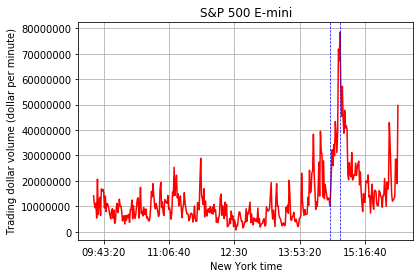

In [274]:
#plotting trading dollar volume minute by minute for S&P 500 E‐mini

plt.ticklabel_format(style = 'plain')

plt.plot(newminitr.index.time , newminitr.Dolv, 'r') 

plt.xlabel('New York time')
plt.ylabel('Trading dollar volume (dollar per minute)')

plt.title('S&P 500 E‐mini')

plt.axvline(x = datetime.time(14, 32, 0), color='b', linestyle='--', linewidth=0.7)
plt.axvline(x = datetime.time(14, 45, 0), color='b', linestyle='--', linewidth=0.7)

plt.grid()


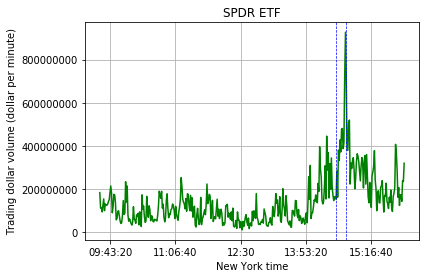

In [275]:
#plotting trading dollar volume minute by minute for SPDR ET

plt.ticklabel_format(style = 'plain')

plt.plot(newetftr.index.time , newetftr.Dolv, 'g' ) 
plt.xlabel('New York time')
plt.ylabel('Trading dollar volume (dollar per minute)')

plt.axvline(x = datetime.time(14, 32), color='b', linestyle='--', linewidth=0.7)
plt.axvline(x = datetime.time(14, 45), color='b', linestyle='--', linewidth=0.7)
plt.title('SPDR ETF')

plt.grid()


Plots realized volatility the E‐mini and SPY over various time periods and for various exchanges. The solid vertical lines indicate the timing of the flash crash	

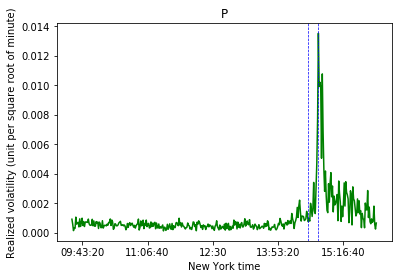

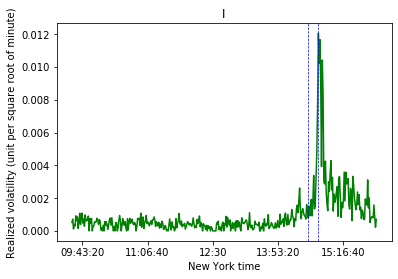

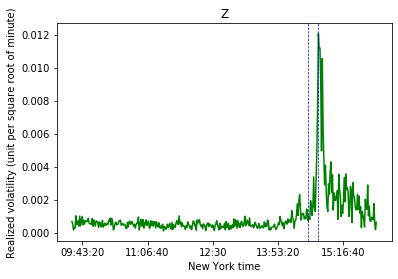

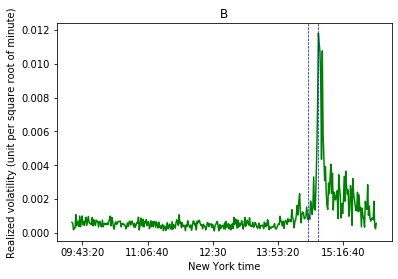

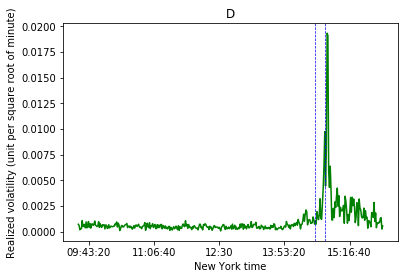

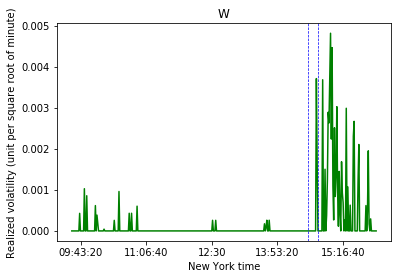

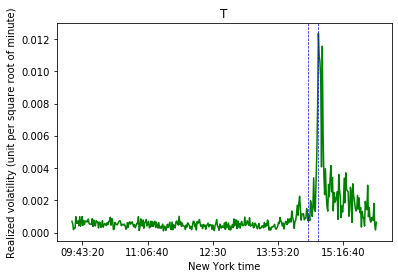

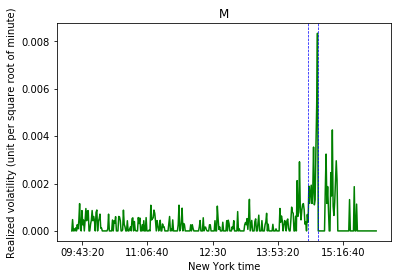

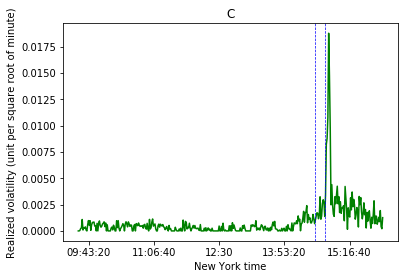

In [276]:
Sset = set(etftr['exchange'])

llist = []
llistind = [] # indexes of exchanges
llist2 = []

for i in Sset:
    exch = etftr[etftr['exchange']==i][['time_m','price','exchange']]
    llist.append(exch)
    llistind.append(i)

Nlist = len(llist)    

for i in range(Nlist):
    llist2.append(llist[i].set_index('time_m').resample('15S').mean()) # get average price
    
    llist2[i]['log_ret'] = (np.log(llist2[i].price) - np.log(llist2[i].price.shift(1)))**2
    llist2[i]=llist2[i].resample('T').sum()


    plt.ticklabel_format(style = 'plain')

    plt.plot(llist2[i].index.time , llist2[i]['log_ret']**(1/2), 'g' ) 
    plt.xlabel('New York time')
    plt.ylabel('Realized volatility (unit per square root of minute)')

    plt.title(llistind[i])
    plt.axvline(x = datetime.time(14, 32), color='b', linestyle='--', linewidth=0.7)
    plt.axvline(x = datetime.time(14, 45), color='b', linestyle='--', linewidth=0.7)
    
    plt.show()
    


Расшифровка индексов, отвечающих за биржы:
    
B: NASDAQ OMX BX, Inc. 
C: National Stock Exchange Inc. (NSX)
D: FINRA ADF
I: LLC (ISE)
M: Chicago Stock Exchange
P: NYSE Arca
W: CBOE
Z: Bats BZX Exchange
T: NASDAQ Stock Exchange, LLC (in Tape A, B securities)

Аналогичная работа, сделанная для E-mini:

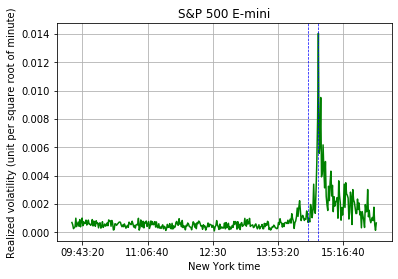

In [289]:
#plotting realized volatility minute by minute for S&P 500

emini = pd.DataFrame()
emini['Date-Time'] = minitr['Date-Time']
emini['Price'] = minitr['Price']

emini=emini.set_index('Date-Time').resample('15S').mean()

emini['log_ret'] = (np.log(emini.Price) - np.log(emini.Price.shift(1)))**2
emini = emini.resample('T').sum()

plt.ticklabel_format(style = 'plain')

plt.plot(emini.index.time, emini['log_ret']**(1/2), 'g' ) 
plt.xlabel('New York time')
plt.ylabel('Realized volatility (unit per square root of minute)')

plt.title('S&P 500 E‐mini')
plt.axvline(x = datetime.time(14, 32), color='b', linestyle='--', linewidth=0.7)
plt.axvline(x = datetime.time(14, 45), color='b', linestyle='--', linewidth=0.7)
plt.grid()

Анализ этик графиков даёт следующие результаты: во всех случаях мы наблюдаем пик волатильности в районе 14:45. Также для бирж D и С наблюдается задержка по времени для пика волатильности. Волатильность для W ведёт себя отличным от остальных бирж способом.

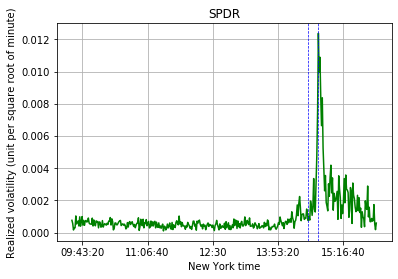

In [290]:
#plotting realized volatility minute by minute for SPDR (all exchanges)

etf = pd.DataFrame()
etf['time_m'] = etftr['time_m']
etf['price'] = etftr['price']

etf = etf.set_index('time_m').resample('15S').mean()

etf['log_ret'] = (np.log(etf.price) - np.log(etf.price.shift(1)))**2
etf = etf.resample('T').sum()

plt.ticklabel_format(style = 'plain')

plt.plot(etf.index.time, etf['log_ret']**(1/2), 'g' ) 
plt.xlabel('New York time')
plt.ylabel('Realized volatility (unit per square root of minute)')

plt.title('SPDR')
plt.axvline(x = datetime.time(14, 32), color='b', linestyle='--', linewidth=0.7)
plt.axvline(x = datetime.time(14, 45), color='b', linestyle='--', linewidth=0.7)
plt.grid()

### 4

In [291]:
#normalizing the futures and spot prices
etftr['nprice'] = etftr['price'] / list(etftr['price'])[0] * 100

minitr['nprice'] = minitr['Price'] / list(minitr['Price'])[0] * 100


C:\Root_folder\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


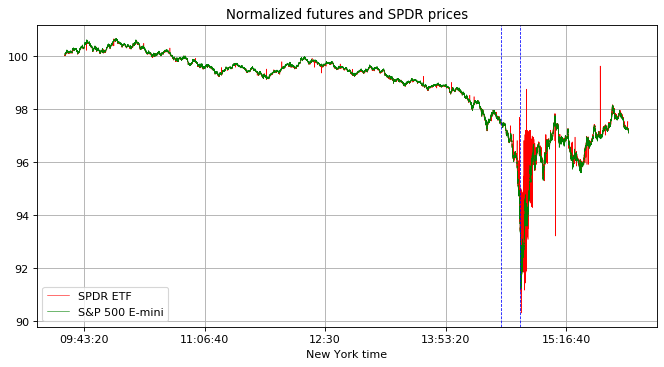

In [292]:
#plotting Normalized futures and SPDR prices
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.ticklabel_format(style = 'plain')

plt.plot(etftr['time_m'].dt.time, etftr['nprice'], 'r', linewidth=0.5, label='SPDR ETF' ) 
plt.plot(minitr['Date-Time'].dt.time, minitr['nprice'], 'g', linewidth=0.5 , label='S&P 500 E‐mini' ) 

plt.xlabel('New York time')
#plt.ylabel('Normalized prices')

plt.title('Normalized futures and SPDR prices')
plt.axvline(x = datetime.time(14, 32), color='b', linestyle='--', linewidth=0.7)
plt.axvline(x = datetime.time(14, 45), color='b', linestyle='--', linewidth=0.7)

plt.legend(loc='lower left')

plt.grid()

<Figure size 800x400 with 0 Axes>

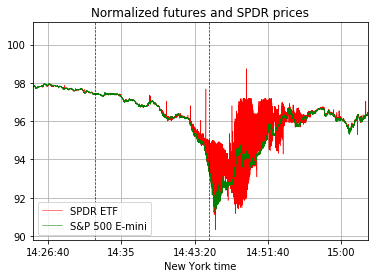

In [295]:
#plotting Normalized futures and SPDR prices during the Flash Crash
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')

fig, ax = plt.subplots()
ax.plot_date(etftr['time_m'].dt.time, etftr['nprice'], 'r', linewidth=0.5, label='SPDR ETF' ) 
ax.set_xlim([datetime.time(14, 25, 0), datetime.time(15, 3, 0)])
ax.plot_date(minitr['Date-Time'].dt.time, minitr['nprice'], 'g', linewidth=0.5, label='S&P 500 E‐mini' ) 

plt.xlabel('New York time')
#plt.ylabel('Normalized prices')

plt.title('Normalized futures and SPDR prices')
plt.axvline(x = datetime.time(14, 32), color='b', linestyle='--', linewidth=0.7)
plt.axvline(x = datetime.time(14, 45), color='b', linestyle='--', linewidth=0.7)
plt.legend(loc='lower left')

plt.grid()


###  5 Spreads and depth

In [298]:
#spread and depth calculation
miniqu['spread'] = miniqu['Ask Price'] - miniqu['Bid Price']
miniqu['depth'] = (miniqu['Ask Size'] + miniqu['Bid Size'])/2
etfqu['spread'] = etfqu['ask'] - etfqu['bid']
etfqu['depth'] = (etfqu['bidsize'] + etfqu['asksize'])/2

Глубину считаем как среднее между asksize и bidsize

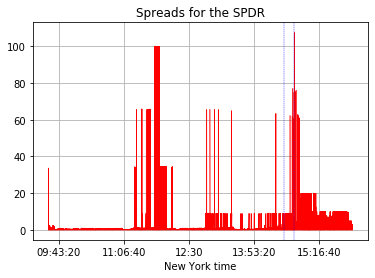

In [299]:
#plotting the spreads for the SPDR


plt.ticklabel_format(style = 'plain')

plt.plot(etfqu['time_m'].dt.time, etfqu['spread'], 'r', linewidth=0.5) 


plt.xlabel('New York time')
#plt.ylabel('Spreads')

plt.title('Spreads for the SPDR')


#plt.legend(loc='lower left')
plt.axvline(x = datetime.time(14, 32), color='b', linestyle='--', linewidth=0.4)
plt.axvline(x = datetime.time(14, 45), color='b', linestyle='--', linewidth=0.4)
plt.grid()

Мы наблюдаем два основных пика спредов для SPDR: в районе 11:50 и во время flash crash; в начале дня спред был маленький, в конце дня - повышенный

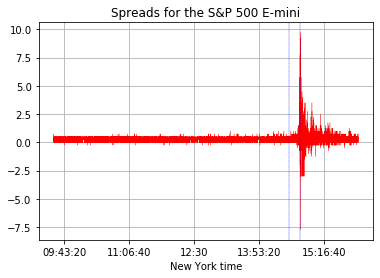

In [300]:
#plotting the spreads for the S&P 500 E‐mini


plt.ticklabel_format(style = 'plain')

plt.plot(miniqu['Date-Time'].dt.time, miniqu['spread'], 'r', linewidth=0.3) 


plt.xlabel('New York time')
#plt.ylabel('Spreads')

plt.title('Spreads for the S&P 500 E‐mini')
plt.axvline(x = datetime.time(14, 32), color='b', linestyle='--', linewidth=0.4)
plt.axvline(x = datetime.time(14, 45), color='b', linestyle='--', linewidth=0.4)

#plt.legend(loc='lower left')

plt.grid()

Для спреда E-mini мы наблюдаем вцелом в течение дня однородную картину (спред небольшой). Но во время flash crash спред увеличился примерно в 10 раз. Объяснение того, что спреды во время flash crash высокие: участники торговли дизоринтированы и не могут точно определить цену активов: те, кто продаёт активы, на всякий случай завышает цену, те, кто покупает - занижает, поэтому спред становится большим. Спред у SPDR в течение дня выше, чем у E-mini, потому, что E-mini более ликвидный актив.

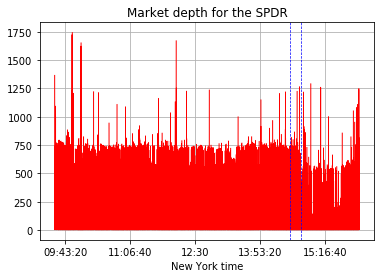

In [303]:
#plotting the market depth for the SPDR


plt.ticklabel_format(style = 'plain')

plt.plot(etfqu['time_m'].dt.time, etfqu['depth'], 'r', linewidth=0.5) 


plt.xlabel('New York time')
#plt.ylabel('Market depth')

plt.title('Market depth for the SPDR')
plt.axvline(x = datetime.time(14, 32), color='b', linestyle='--', linewidth=0.7)
plt.axvline(x = datetime.time(14, 45), color='b', linestyle='--', linewidth=0.7)

#plt.legend(loc='lower left')

plt.grid()

На грифике видно явное падение глубины для SPDR во время crash flash

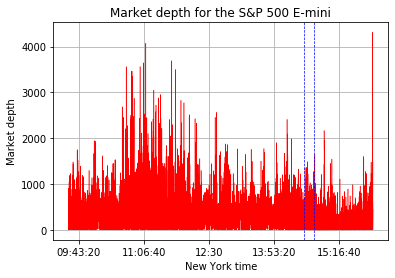

In [304]:
#plotting the market depth for the S&P 500 E‐mini


plt.ticklabel_format(style = 'plain')

plt.plot(miniqu['Date-Time'].dt.time, miniqu['depth'], 'r', linewidth=0.5) 


plt.xlabel('New York time')
plt.ylabel('Market depth')

plt.title('Market depth for the S&P 500 E‐mini')
plt.axvline(x = datetime.time(14, 32), color='b', linestyle='--', linewidth=0.7)
plt.axvline(x = datetime.time(14, 45), color='b', linestyle='--', linewidth=0.7)

#plt.legend(loc='lower left')

plt.grid()

### 6. Average trade size

In [309]:
#finding average trade size

mminitr = pd.DataFrame()
eetftr = pd.DataFrame()

eetftr['time_m'] = etftr['time_m']
mminitr['Date-Time'] = minitr['Date-Time']
eetftr['number'] = 1
mminitr['number'] = 1
eetftr['size'] = etftr['size']
mminitr['Volume'] = minitr['Volume'] 
mminitr = mminitr.set_index('Date-Time').resample('T').sum()
eetftr = eetftr.set_index('time_m').resample('T').sum()
mminitr['trsize']= mminitr['Volume']/mminitr['number']
eetftr['trsize']= eetftr['size']/eetftr['number']


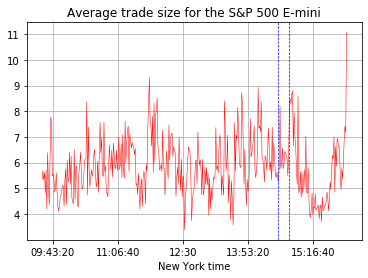

In [310]:
#average trade size for the S&P 500 E-mini

plt.ticklabel_format(style = 'plain')

plt.plot(mminitr.index.time, mminitr['trsize'], 'r', linewidth=0.5) 


plt.xlabel('New York time')


plt.title('Average trade size for the S&P 500 E‐mini')
plt.axvline(x = datetime.time(14, 32), color='b', linestyle='--', linewidth=0.7)
plt.axvline(x = datetime.time(14, 45), color='b', linestyle='--', linewidth=0.7)

#plt.legend(loc='lower left')

plt.grid()

Мы можем наблюдать особенность для E-mini: после flash crash начала образовываться яма в average trade size, но к концу торгового дня average trade size существенно увеличился и достиг максимума.

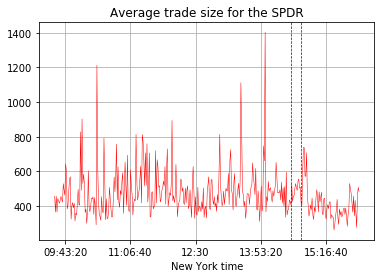

In [311]:
#average trade size for the SPDR

plt.ticklabel_format(style = 'plain')

plt.plot(eetftr.index.time, eetftr['trsize'], 'r', linewidth=0.5) 


plt.xlabel('New York time')


plt.title('Average trade size for the SPDR')
plt.axvline(x = datetime.time(14, 32), color='b', linestyle='--', linewidth=0.7)
plt.axvline(x = datetime.time(14, 45), color='b', linestyle='--', linewidth=0.7)

#plt.legend(loc='lower left')

plt.grid()

Для SPDR также наблюдается падение average trade size сразу после flash crash, но падение не выглядит так отчётливо, как для E-mini.

Однако, эти легкие падения произошли после flash crash, a не во время.

### 7

Realized volatility for all day: (codes for exchanges look above)

In [328]:
s=[]
for i in range(Nlist):
    print(llistind[i],': %.3f' % llist2[i]['log_ret'].sum() ** 0.5)
    s.append(llist2[i]['log_ret'].sum() ** 0.5)

P : 0.035
I : 0.035
Z : 0.035
B : 0.034
D : 0.039
W : 0.013
T : 0.035
M : 0.016
C : 0.037


In [332]:
#realized volatility for E‐mini

print('E-mini: %.3f' %(emini['log_ret'].sum())**(1/2))
s.append(emini['log_ret'].sum()**(1/2))

E-mini: 0.032


In [320]:
#realized volatility for SPDR (all exchanges)

print('SPDR: %.3f' % etf['log_ret'].sum()**(1/2))

SPDR: 0.033


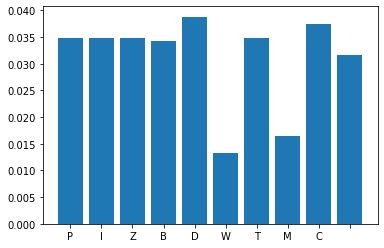

In [335]:
x = range(len(s)) # histogram for the comparison of volatilities
ax = plt.gca()
ax.bar(x, s) 
ax.set_xticks(x)
ax.set_xticklabels(llistind)
plt.show()

### 8

In [336]:
#different exchanges [for trades]

B = etftr[etftr['exchange'] == 'B']
C = etftr[etftr['exchange'] == 'C']
D = etftr[etftr['exchange'] == 'D']
I = etftr[etftr['exchange'] == 'I']
M = etftr[etftr['exchange'] == 'M']
P = etftr[etftr['exchange'] == 'P']
T = etftr[etftr['exchange'] == 'T']
W = etftr[etftr['exchange'] == 'W']
Z = etftr[etftr['exchange'] == 'Z']

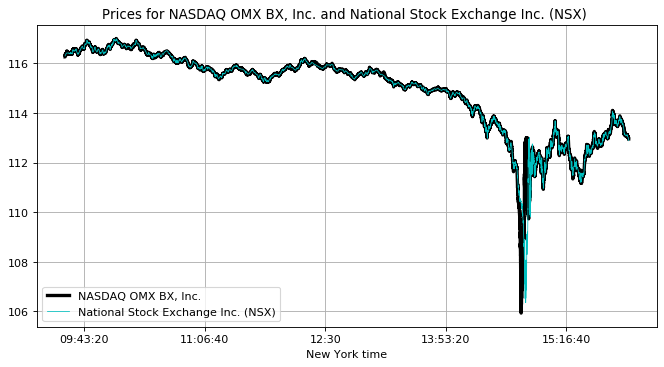

In [337]:
#price changes on some exchanges: pairwise comparison


figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.grid()
plt.ticklabel_format(style = 'plain')

plt.plot(B['time_m'].dt.time, B['price'], 'k', linewidth=3 , label='NASDAQ OMX BX, Inc.' ) 
plt.plot(C['time_m'].dt.time, C['price'], 'c', linewidth=0.7 , label='National Stock Exchange Inc. (NSX)' ) 

plt.xlabel('New York time')


plt.title('Prices for NASDAQ OMX BX, Inc. and National Stock Exchange Inc. (NSX) ')

plt.legend(loc='lower left')


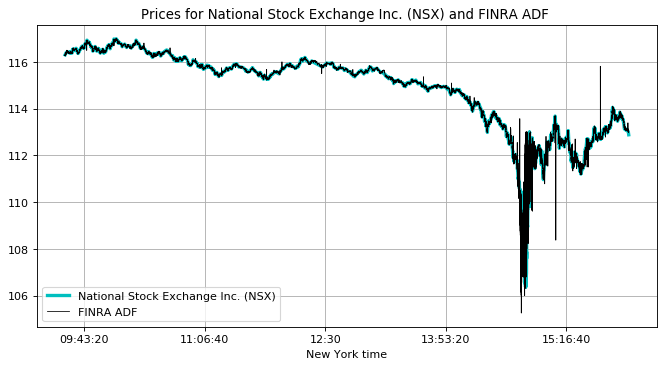

In [338]:
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.grid()
plt.ticklabel_format(style = 'plain')


plt.plot(C['time_m'].dt.time, C['price'], 'c', linewidth=3 , label='National Stock Exchange Inc. (NSX)' ) 
plt.plot(D['time_m'].dt.time, D['price'], 'k', linewidth=0.7 , label='FINRA ADF' ) 
 

plt.xlabel('New York time')


plt.title('Prices for National Stock Exchange Inc. (NSX) and FINRA ADF ')

plt.legend(loc='lower left')

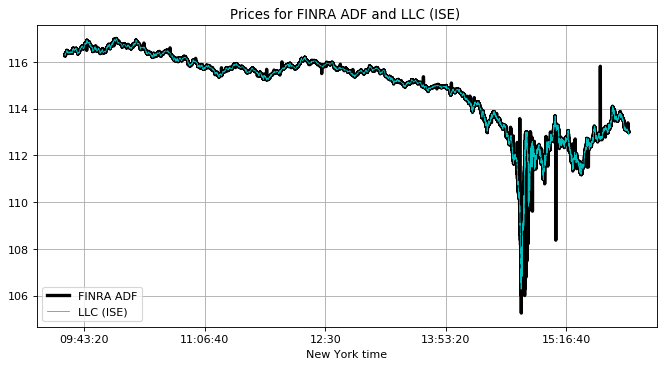

In [339]:
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.grid()
plt.ticklabel_format(style = 'plain')


plt.plot(D['time_m'].dt.time, D['price'], 'k', linewidth=3 , label='FINRA ADF' ) 
plt.plot(I['time_m'].dt.time, I['price'], 'c', linewidth=0.7 , label='LLC (ISE)' ) 
 

plt.xlabel('New York time')


plt.title('Prices for FINRA ADF and LLC (ISE) ')

plt.legend(loc='lower left')

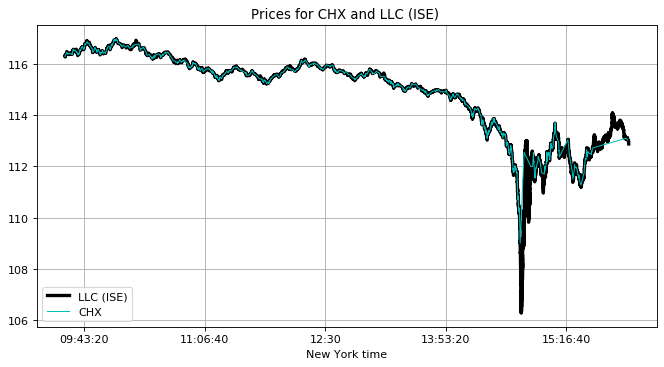

In [340]:
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.grid()
plt.ticklabel_format(style = 'plain')


plt.plot(I['time_m'].dt.time, I['price'], 'k', linewidth=3 , label='LLC (ISE)' ) 
plt.plot(M['time_m'].dt.time, M['price'], 'c', linewidth=0.9 , label='CHX' ) 
 

plt.xlabel('New York time')


plt.title('Prices for CHX and LLC (ISE) ')

plt.legend(loc='lower left')

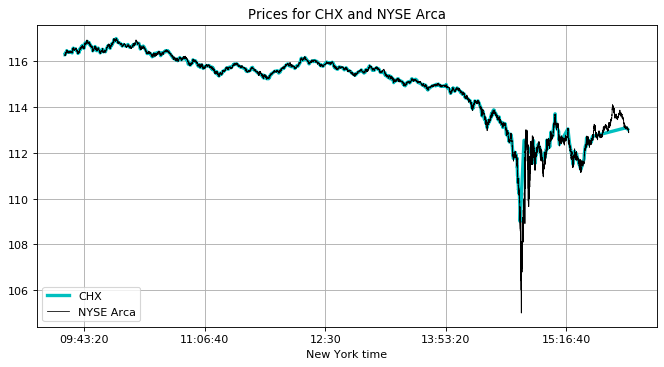

In [341]:
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.grid()
plt.ticklabel_format(style = 'plain')


plt.plot(M['time_m'].dt.time, M['price'], 'c', linewidth=3 , label='CHX' ) 
plt.plot(P['time_m'].dt.time, P['price'], 'k', linewidth=0.7 , label='NYSE Arca' ) 
 

plt.xlabel('New York time')


plt.title('Prices for CHX and NYSE Arca')

plt.legend(loc='lower left')

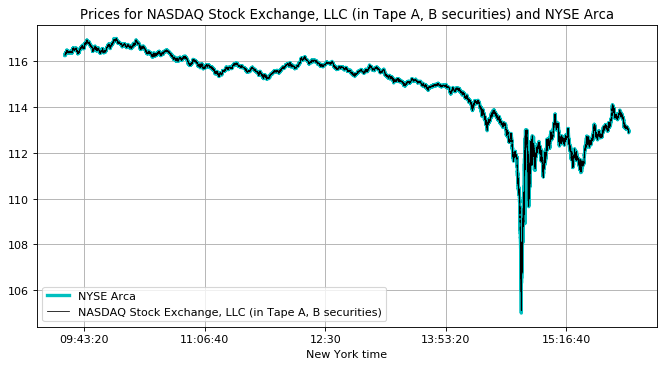

In [342]:
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.grid()
plt.ticklabel_format(style = 'plain')


plt.plot(P['time_m'].dt.time, P['price'], 'c', linewidth=3 , label='NYSE Arca' ) 
plt.plot(T['time_m'].dt.time, T['price'], 'k', linewidth=0.7 , label='NASDAQ Stock Exchange, LLC (in Tape A, B securities)' ) 
 

plt.xlabel('New York time')


plt.title('Prices for NASDAQ Stock Exchange, LLC (in Tape A, B securities) and NYSE Arca')

plt.legend(loc='lower left')

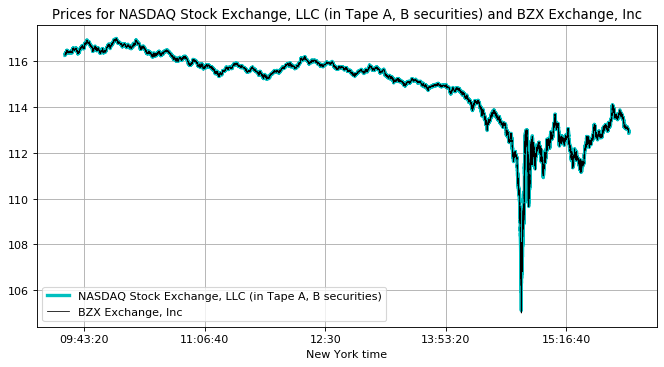

In [343]:
figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
plt.grid()
plt.ticklabel_format(style = 'plain')


plt.plot(T['time_m'].dt.time, T['price'], 'c', linewidth=3 , label='NASDAQ Stock Exchange, LLC (in Tape A, B securities)' ) 
plt.plot(Z['time_m'].dt.time, Z['price'], 'k', linewidth=0.7 , label='BZX Exchange, Inc' ) 
 

plt.xlabel('New York time')


plt.title('Prices for NASDAQ Stock Exchange, LLC (in Tape A, B securities) and BZX Exchange, Inc')

plt.legend(loc='lower left')

### 9

In [291]:
# The correlation of price changes for E‐mini and SPDR for different horizons

#for S&P500
df = pd.DataFrame()
df['emini'] = minitr['Price'] 
df['Date-Time'] = minitr['Date-Time'] 
df = df.set_index('Date-Time').resample('S').mean()
emini = (df['emini'])

#for SPDR
df = pd.DataFrame()
df['spdr'] = etftr['price'] 
df['time_m'] = etftr['time_m'] 
df = df.set_index('time_m').resample('S').mean()
spdr = (df['spdr'])

#time restriction: 16:00 (in order we have equal number of rows for both datasets)
time_str = '16:00:00'
time_object = datetime.datetime.strptime(time_str, '%H:%M:%S').time()
emini = emini[ emini.index.time < time_object ]

In [292]:
dff = pd.DataFrame()
dff['emini'] = list(emini)
dff['spdr'] = list(spdr)
dff.dropna()
dff.corr()

,emini,spdr
emini,1.000000,0.991925
spdr,0.991925,1.000000


We can observe that the correlation is 0.991925 during the whole day. Let's examine other time intervals. 

In [296]:
#during flash crash: the timing of the crash from 14:32 to 14:45 

time_str1 = '14:32:00'
time_str2 = '14:45:00'
time_object1 = datetime.datetime.strptime(time_str1, '%H:%M:%S').time()
time_object2 = datetime.datetime.strptime(time_str2, '%H:%M:%S').time()
emini = emini[ emini.index.time >= time_object1 ]
emini = emini[ emini.index.time <= time_object2 ]
spdr = spdr[ spdr.index.time >= time_object1 ]
spdr = spdr[ spdr.index.time <= time_object2 ]

dff = pd.DataFrame()
dff['emini'] = list(emini)
dff['spdr'] = list(spdr)
dff.dropna()
dff.corr()

,emini,spdr
emini,1.000000,0.999928
spdr,0.999928,1.000000


In [300]:
#we can observe that the correlation is 0.999928 during the flash crash. 
#There is no wonder if we take a look at the graph with normalized futures and SPDR prices during that time.
#Now let's take a look at recovery period from 14:45 to 14:57 (where the arbitrage relationship was very weak).


#for S&P500
df = pd.DataFrame()
df['emini'] = minitr['Price'] 
df['Date-Time'] = minitr['Date-Time'] 
df = df.set_index('Date-Time').resample('S').mean()
emini = (df['emini'])

#for SPDR
df = pd.DataFrame()
df['spdr'] = etftr['price'] 
df['time_m'] = etftr['time_m'] 
df = df.set_index('time_m').resample('S').mean()
spdr = (df['spdr'])

#time restriction
time_str1 = '14:45:00'
time_str2 = '14:57:00'
time_object1 = datetime.datetime.strptime(time_str1, '%H:%M:%S').time()
time_object2 = datetime.datetime.strptime(time_str2, '%H:%M:%S').time()
emini = emini[ emini.index.time >= time_object1 ]
emini = emini[ emini.index.time <= time_object2 ]
spdr = spdr[ spdr.index.time >= time_object1 ]
spdr = spdr[ spdr.index.time <= time_object2 ]


dff = pd.DataFrame()
dff['emini'] = list(emini)
dff['spdr'] = list(spdr)
dff.dropna()
dff.corr()

,emini,spdr
emini,1.000000,0.830803
spdr,0.830803,1.000000


In [304]:
#So, now the correlation is much less: 0.830803 during that period. 
#Finally, let's examine the correlation on the time interval without Flash Crash and the recovery period. 

#for S&P500
df = pd.DataFrame()
df['emini'] = minitr['Price'] 
df['Date-Time'] = minitr['Date-Time'] 
df = df.set_index('Date-Time').resample('S').mean()
emini = (df['emini'])

#for SPDR
df = pd.DataFrame()
df['spdr'] = etftr['price'] 
df['time_m'] = etftr['time_m'] 
df = df.set_index('time_m').resample('S').mean()
spdr = (df['spdr'])

#time restriction
time_str1 = '14:32:00'
time_str2 = '14:57:00'
time_object1 = datetime.datetime.strptime(time_str1, '%H:%M:%S').time()
time_object2 = datetime.datetime.strptime(time_str2, '%H:%M:%S').time()
emini = emini[ (emini.index.time < time_object1) | (emini.index.time > time_object2)  ]
spdr = spdr[ (spdr.index.time < time_object1) | (spdr.index.time > time_object2)  ]



#time restriction: 16:00 (in order we have equal number of rows for both datasets)
time_str = '16:00:00'
time_object = datetime.datetime.strptime(time_str, '%H:%M:%S').time()
emini = emini[ emini.index.time < time_object ]


dff = pd.DataFrame()
dff['emini'] = list(emini)
dff['spdr'] = list(spdr)
dff.dropna()
dff.corr()


,emini,spdr
emini,1.000000,0.999955
spdr,0.999955,1.000000


 the correlation is 0.999955- the highest rate. 